In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable

import numpy as np
import cvxpy as cp

from free_flyer.free_flyer import FreeFlyer
import pickle, os

In [2]:
#load train/test data
prob = FreeFlyer() #use default config, pass different config file oth.
config_fn = './free_flyer/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
# p_train, x_train, u_train, y_train, c_train, times_train = pickle.load(train_file)
train_data = pickle.load(train_file)
train_file.close()
x_train = train_data[1]
y_train = train_data[3]

test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
x_test = test_data[1]
c_test = test_data[4]
times_test = test_data[5]
test_file.close()
n_test = x_test.shape[0]
n_test = 25

# naive MLOPT classifier

In [3]:
from solvers.mlopt import MLOPT

system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_obj = MLOPT(system, prob, prob_features)

n_features = 36
mlopt_obj.construct_strategies(n_features, train_data)
print(mlopt_obj.n_strategies)

64914


In [4]:
mlopt_obj.setup_network()

fn_saved = 'models/mlopt_free_flyer_20200624_1449.pt'
mlopt_obj.load_network(fn_saved)

mlopt_obj.model

FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=64914, bias=True)
  )
)

In [ ]:
mlopt_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_obj.train()
print(mlopt_obj.model_fn)

In [5]:
n_succ = 0
count = 0

costs_naive_mlopt = []
total_time_naive_mlopt = []
num_solves_naive_mlopt = []

cost_ratios_naive_mlopt = []

for ii in range(n_test):
    prob_params = {}
    p_test = test_data[0]
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals = mlopt_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_naive_mlopt += [cost]
            total_time_naive_mlopt += [total_time]
            num_solves_naive_mlopt += [n_evals]

            true_cost = c_test[ii]
            cost_ratios_naive_mlopt += [cost / true_cost]
    except:
        continue

costs_naive_mlopt = np.array(costs_naive_mlopt)
cost_ratios_naive_mlopt = np.array(cost_ratios_naive_mlopt)
total_time_naive_mlopt = np.array(total_time_naive_mlopt)
num_solves_naive_mlopt = np.array(num_solves_naive_mlopt, dtype=int)

mlopt_naive_percentage = 100 * float(n_succ) / float(count)
mlopt_naive_percentage

44.0

In [ ]:
idx = np.random.randint(train_data[1].shape[0])
x0 = train_data[0]['x0'][idx]
n_obs = train_data[0]['obstacles'][idx].shape[1]
posmin, posmax = mlopt_obj.problem.posmin, mlopt_obj.problem.posmax

obstacles = []
for ii_obs in range(n_obs):
    obs = train_data[0]['obstacles'][idx][:,ii_obs]
    obstacles.append(obs)

if len(obstacles) is n_obs:
    plt.axes()
    for obstacle in obstacles:
        rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                                  obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                                 fc='red', ec='blue')
        plt.gca().add_patch(rectangle)
        plt.axis('scaled')

    circle = plt.Circle((x0[0],x0[1]), 0.04, fc='blue',ec="green")
    plt.gca().add_patch(circle)    

    ax = plt.gca()
    ax.margins(0)
    ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
    plt.show()

# task-specific MLOPT

In [6]:
from solvers.mlopt_ff import MLOPT_FF

In [7]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_ts_obj = MLOPT_FF(system, prob, prob_features)

n_features = 36 + prob.n_obs
mlopt_ts_obj.construct_strategies(n_features, train_data)
print(mlopt_ts_obj.n_strategies)

430


In [8]:
mlopt_ts_obj.setup_network()

fn_saved = 'models/mloptff_free_flyer_20200702_1648.pt'
mlopt_ts_obj.load_network(fn_saved)

mlopt_ts_obj.model

Loading presaved classifier model from models/mloptff_free_flyer_20200702_1648.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=44, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=430, bias=True)
  )
)

In [ ]:
mlopt_ts_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_ts_obj.train(verbose=True)
print(mlopt_ts_obj.model_fn)

In [9]:
n_succ = 0
count = 0

costs_mlopt = []
total_time_mlopt = []
num_solves_mlopt = []

cost_ratios_mlopt = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    prob_params = {}
    p_test = test_data[0]
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals = mlopt_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_mlopt += [cost]
            total_time_mlopt += [total_time]
            num_solves_mlopt += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_mlopt += [cost / true_cost]
    except:
        continue

costs_mlopt = np.array(costs_mlopt)
cost_ratios_mlopt = np.array(cost_ratios_mlopt)
total_time_mlopt = np.array(total_time_mlopt)
num_solves_mlopt = np.array(num_solves_mlopt, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

mlopt_percentage = 100 * float(n_succ) / float(count)
mlopt_percentage

44.0

# test Regression solver

In [10]:
from solvers.regression import Regression

system = 'free_flyer'
prob_features = ['x0', 'obstacles']
reg_obj = Regression(system, prob, prob_features)

n_features = 36
reg_obj.construct_strategies(n_features, train_data)

In [11]:
reg_obj.setup_network()

reg_obj.model

FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=36, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=160, bias=True)
  )
)

In [ ]:
mlopt_obj.training_params['TRAINING_ITERATIONS'] = 500
reg_obj.train()
print(reg_obj.model_fn)

In [12]:
n_succ = 0
count = 0

costs_reg = []
total_time_reg = []
num_solves_reg = []

cost_ratios_reg = []

for ii in range(n_test):
    prob_params = {}
    p_test = test_data[0]
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time = reg_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_reg += [cost]
            total_time_reg += [total_time]
            num_solves_reg += [1]

            true_cost = c_test[ii]
            cost_ratios_reg += [cost / true_cost]
    except:
        continue

costs_reg = np.array(costs_reg)
cost_ratios_reg = np.array(cost_ratios_reg)
total_time_reg = np.array(total_time_reg)
num_solves_reg = np.array(num_solves_reg, dtype=int)

reg_percentage = 100 * float(n_succ) / float(count)
reg_percentage

0.0

# Results

In [13]:
import math
import seaborn as sns
sns.set(font_scale=2., font="serif", style="whitegrid")
import pandas as pd

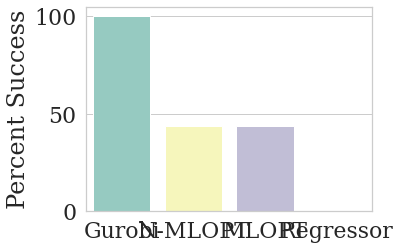

In [21]:
results = {'Gurobi':[100.], 'N-MLOPT':[mlopt_naive_percentage], 'MLOPT':[mlopt_percentage], 'Regressor':[reg_percentage]}
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
# # figure.savefig("loss.pdf")

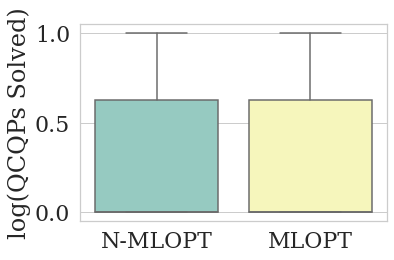

In [20]:
results = {'N-MLOPT':np.log10(num_solves_naive_mlopt), \
          'MLOPT':np.log10(num_solves_mlopt)} #, 'Regressor':np.log10(num_solves_reg)}
results = pd.DataFrame(results)

ax1 = sns.boxplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="log(QCQPs Solved)")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

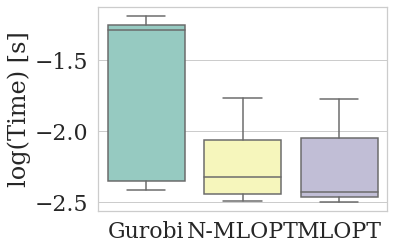

In [19]:
results = {'Gurobi': np.log10(total_time_ip), 'N-MLOPT':np.log10(total_time_naive_mlopt), \
          'MLOPT':np.log10(total_time_mlopt)} #, 'Regressor':np.log10(total_time_reg)}
results = pd.DataFrame(results)

ax1 = sns.boxplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="log(Time) [s]")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

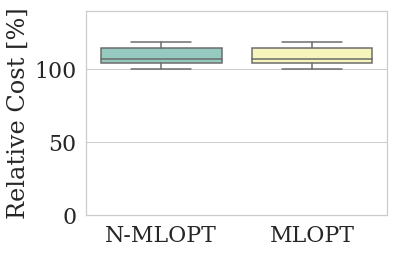

In [18]:
results = {'N-MLOPT':100.*cost_ratios_naive_mlopt, \
          'MLOPT':100.*cost_ratios_mlopt} #, 'Regressor':100.*cost_ratios_reg}
results = pd.DataFrame(results)

ax1 = sns.boxplot(data=results, palette="Set3")
ax1.set(xlabel="", ylabel="Relative Cost [%]")

plt.tight_layout()
plt.ylim(0, int(math.ceil(np.max(np.maximum(costs_ip, costs_naive_mlopt, costs_mlopt)) / 10.0)) * 10)

figure = ax1.get_figure()
# figure.savefig("loss.pdf")